In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Pytorch-Models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
/content/gdrive/.shortcut-targets-by-id/1aJsbt04Jz9xcLP_lg7fvP4Bpdce6GQlC/Pytorch-Models


In [ ]:
!pip install onnx

In [ ]:
import torch
from torchvision.models.detection import keypointrcnn_resnet50_fpn

class KeypointRCNNWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x):
        images = [img for img in x]
        outputs = self.model(images)
        out = outputs[0]
        keypoint_scores = out.get("keypoints_scores", out["keypoints"][:, :, 2])
        return (out["boxes"], out["labels"], out["scores"], out["keypoints"], keypoint_scores)

model = keypointrcnn_resnet50_fpn(pretrained=True)
model.eval()

wrapped_model = KeypointRCNNWrapper(model)
wrapped_model.eval()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/keypointrcnn_resnet50_fpn_coco-fc266e95.pth" to /root/.cache/torch/hub/checkpoints/keypointrcnn_resnet50_fpn_coco-fc266e95.pth
100%|██████████| 226M/226M [00:01<00:00, 174MB/s]


KeypointRCNNWrapper(
  (model): KeypointRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): FrozenBatchNorm2d(64, eps=0.0)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [ ]:
dummy_input = torch.randn(1, 3, 480, 640)

torch.onnx.export(
    wrapped_model,
    dummy_input,
    "keypointrcnn_pose_human.onnx",
    opset_version=13,
    input_names=["input"],
    output_names=["boxes", "labels", "scores", "keypoints", "keypoint_scores"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "boxes": {0: "num_boxes"},
        "labels": {0: "num_boxes"},
        "scores": {0: "num_boxes"},
        "keypoints": {0: "num_boxes"},
        "keypoint_scores": {0: "num_boxes"},
    },
    do_constant_folding=True,
)

print("ONNX export completed successfully!")

/tmp/ipython-input-4004147843.py:10: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  images = [img for img in x]


ONNX export completed successfully!


In [ ]:
!pip uninstall onnxruntime -y
!pip install onnxruntime-gpu

In [4]:
import onnxruntime
import numpy as np
import cv2
import torch

# Load image and preprocess (assume 640x640)
img_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/coco_5k/Male-Posing.jpg"

img = cv2.imread(img_path)
img_resized = cv2.resize(img, (640, 480))
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Run inference
session = onnxruntime.InferenceSession("keypointrcnn_pose_human.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: img_input})

# outputs is a list, often like [boxes, scores, keypoints]
print("Output:", [o.shape for o in outputs])

Output: [(9, 4), (9,), (9,), (9, 17, 3), (9, 17)]


In [ ]:
(9, 4)       → boxes  (9 detections, 4 coords each)
(9,)         → labels (class IDs for each detection)
(9,)         → scores (confidence scores for each detection)
(9, 17, 3)   → keypoints (x, y, visibility for 17 human keypoints)
(9, 17)      → keypoint_scores (confidence for each keypoint)

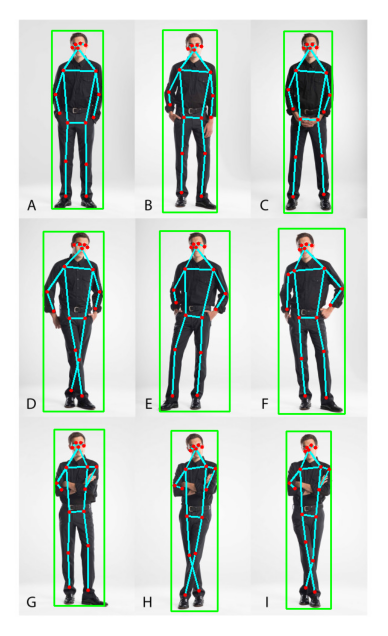

In [5]:
import torch
from torchvision.ops import nms
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Unpack outputs correctly
boxes, labels, scores, keypoints, kp_scores = outputs

# Convert to numpy arrays if needed
boxes = np.array(boxes)
labels = np.array(labels)
scores = np.array(scores)
keypoints = np.array(keypoints)
kp_scores = np.array(kp_scores)

# Apply NMS
boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
scores_tensor = torch.tensor(scores, dtype=torch.float32)
nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

# Filter after NMS
boxes = boxes_tensor[nms_indices].numpy()
scores = scores_tensor[nms_indices].numpy()
keypoints = keypoints[nms_indices]
kp_scores = kp_scores[nms_indices]

# Resize back to original scale
h_orig, w_orig = img.shape[:2]
scale_x = w_orig / 640  # width scale
scale_y = h_orig / 480  # height scale careful: dummy input was (480, 640)

conf_thr = 0.2

# COCO 17 keypoint connections
pairs = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [0, 5], [0, 6],       # Nose to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

# Store scaled keypoints
all_kpts_scaled = []

for i in range(len(scores)):
    if scores[i] < conf_thr:
        continue

    # Draw bounding box
    x1, y1, x2, y2 = boxes[i]
    x1 = int(x1 * scale_x)
    y1 = int(y1 * scale_y)
    x2 = int(x2 * scale_x)
    y2 = int(y2 * scale_y)

    x1 = max(0, min(x1, w_orig - 1))
    y1 = max(0, min(y1, h_orig - 1))
    x2 = max(0, min(x2, w_orig - 1))
    y2 = max(0, min(y2, h_orig - 1))

    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Scale keypoints
    kpts_scaled = []
    for k in range(keypoints.shape[1]):
        kpt = keypoints[i][k]

        # Make sure it's at least a 1D array
        if np.ndim(kpt) == 1 and kpt.shape[0] >= 2:
            kx, ky = kpt[0], kpt[1]
        else:
            kpts_scaled.append(None)
            continue

        # Score check
        if kp_scores[i][k] > 0.3:
            kx = int(kx * scale_x)
            ky = int(ky * scale_y)
            kpts_scaled.append((kx, ky))
        else:
            kpts_scaled.append(None)

    all_kpts_scaled.append(kpts_scaled)

# Draw skeleton connections
for kpts_scaled in all_kpts_scaled:
    for (p1, p2) in pairs:
        if p1 < len(kpts_scaled) and p2 < len(kpts_scaled):
            if kpts_scaled[p1] is not None and kpts_scaled[p2] is not None:
                cv2.line(img, kpts_scaled[p1], kpts_scaled[p2], (255, 255, 0), 2)

# Draw keypoints
for kpts_scaled in all_kpts_scaled:
    for pt in kpts_scaled:
        if pt is not None:
            cv2.circle(img, pt, 3, (0, 0, 255), -1)

# Show result
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

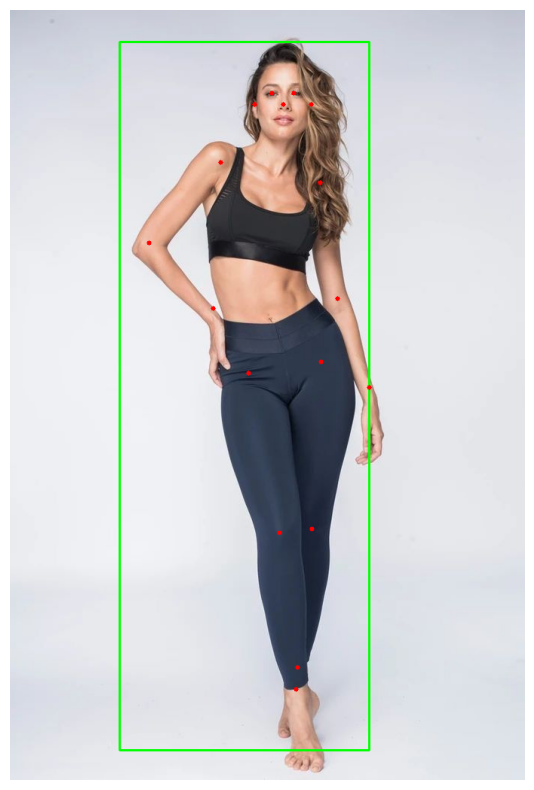

In [ ]:
import cv2
import numpy as np
import onnxruntime
import torch
from torchvision.ops import nms
import matplotlib.pyplot as plt

# Resize with padding to target size while keeping aspect ratio
def resize_with_pad(image, target_size=(480, 640)):
    h, w = image.shape[:2]
    target_h, target_w = target_size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    return padded, scale, pad_left, pad_top

# Load your image here
#img_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/coco_5k/Male-Posing.jpg"

img_path = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests/pose (7).jpg"
img = cv2.imread(img_path)
h_orig, w_orig = img.shape[:2]

# Preprocess
input_size = (480, 640)  # H, W for your model input
img_resized, scale, pad_left, pad_top = resize_with_pad(img, input_size)
img_input = img_resized.astype(np.float32) / 255.0
img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

# Load ONNX model
session = onnxruntime.InferenceSession("keypointrcnn_pose_human.onnx", providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name

# Run inference
outputs = session.run(None, {input_name: img_input})

boxes, labels, scores, keypoints, kp_scores = outputs

# Convert to numpy arrays
boxes = np.array(boxes)
scores = np.array(scores)
keypoints = np.array(keypoints)
kp_scores = np.array(kp_scores)

# Apply NMS
boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
scores_tensor = torch.tensor(scores, dtype=torch.float32)
keep = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

boxes = boxes_tensor[keep].numpy()
scores = scores_tensor[keep].numpy()
keypoints = keypoints[keep]
kp_scores = kp_scores[keep]

# Minimal fix: if only one detection, ensure keypoints and kp_scores have batch dimension
if len(boxes) == 1:
    if keypoints.ndim == 2:  # shape (17, 3) instead of (1, 17, 3)
        keypoints = keypoints[np.newaxis, ...]
    if kp_scores.ndim == 1:  # shape (17,) instead of (1, 17)
        kp_scores = kp_scores[np.newaxis, ...]

# Remove padding and scale back to original image size
def rescale_coords(coord, scale, pad):
    return (coord - pad) / scale

conf_thr = 0.3

img_vis = img.copy()

for i in range(len(scores)):
    if scores[i] < conf_thr:
        continue
    # Boxes: rescale and clip
    x1, y1, x2, y2 = boxes[i]
    x1 = rescale_coords(x1, scale, pad_left)
    x2 = rescale_coords(x2, scale, pad_left)
    y1 = rescale_coords(y1, scale, pad_top)
    y2 = rescale_coords(y2, scale, pad_top)

    x1, x2 = np.clip([x1, x2], 0, w_orig - 1).astype(int)
    y1, y2 = np.clip([y1, y2], 0, h_orig - 1).astype(int)

    cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Keypoints: rescale and draw
    for k, kpt in enumerate(keypoints[i]):
        kp_score = kp_scores[i][k]
        if kp_score > conf_thr:
            x_kp, y_kp, _ = kpt
            x_kp = rescale_coords(x_kp, scale, pad_left)
            y_kp = rescale_coords(y_kp, scale, pad_top)
            x_kp = int(np.clip(x_kp, 0, w_orig - 1))
            y_kp = int(np.clip(y_kp, 0, h_orig - 1))
            cv2.circle(img_vis, (x_kp, y_kp), 3, (0, 0, 255), -1)

plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [6]:
# Resize with padding to target size while keeping aspect ratio
def resize_with_pad(image, target_size=(480, 640)):
    h, w = image.shape[:2]
    target_h, target_w = target_size
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(image, (new_w, new_h))
    pad_top = (target_h - new_h) // 2
    pad_bottom = target_h - new_h - pad_top
    pad_left = (target_w - new_w) // 2
    pad_right = target_w - new_w - pad_left
    padded = cv2.copyMakeBorder(resized, pad_top, pad_bottom, pad_left, pad_right,
                                borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    return padded, scale, pad_left, pad_top

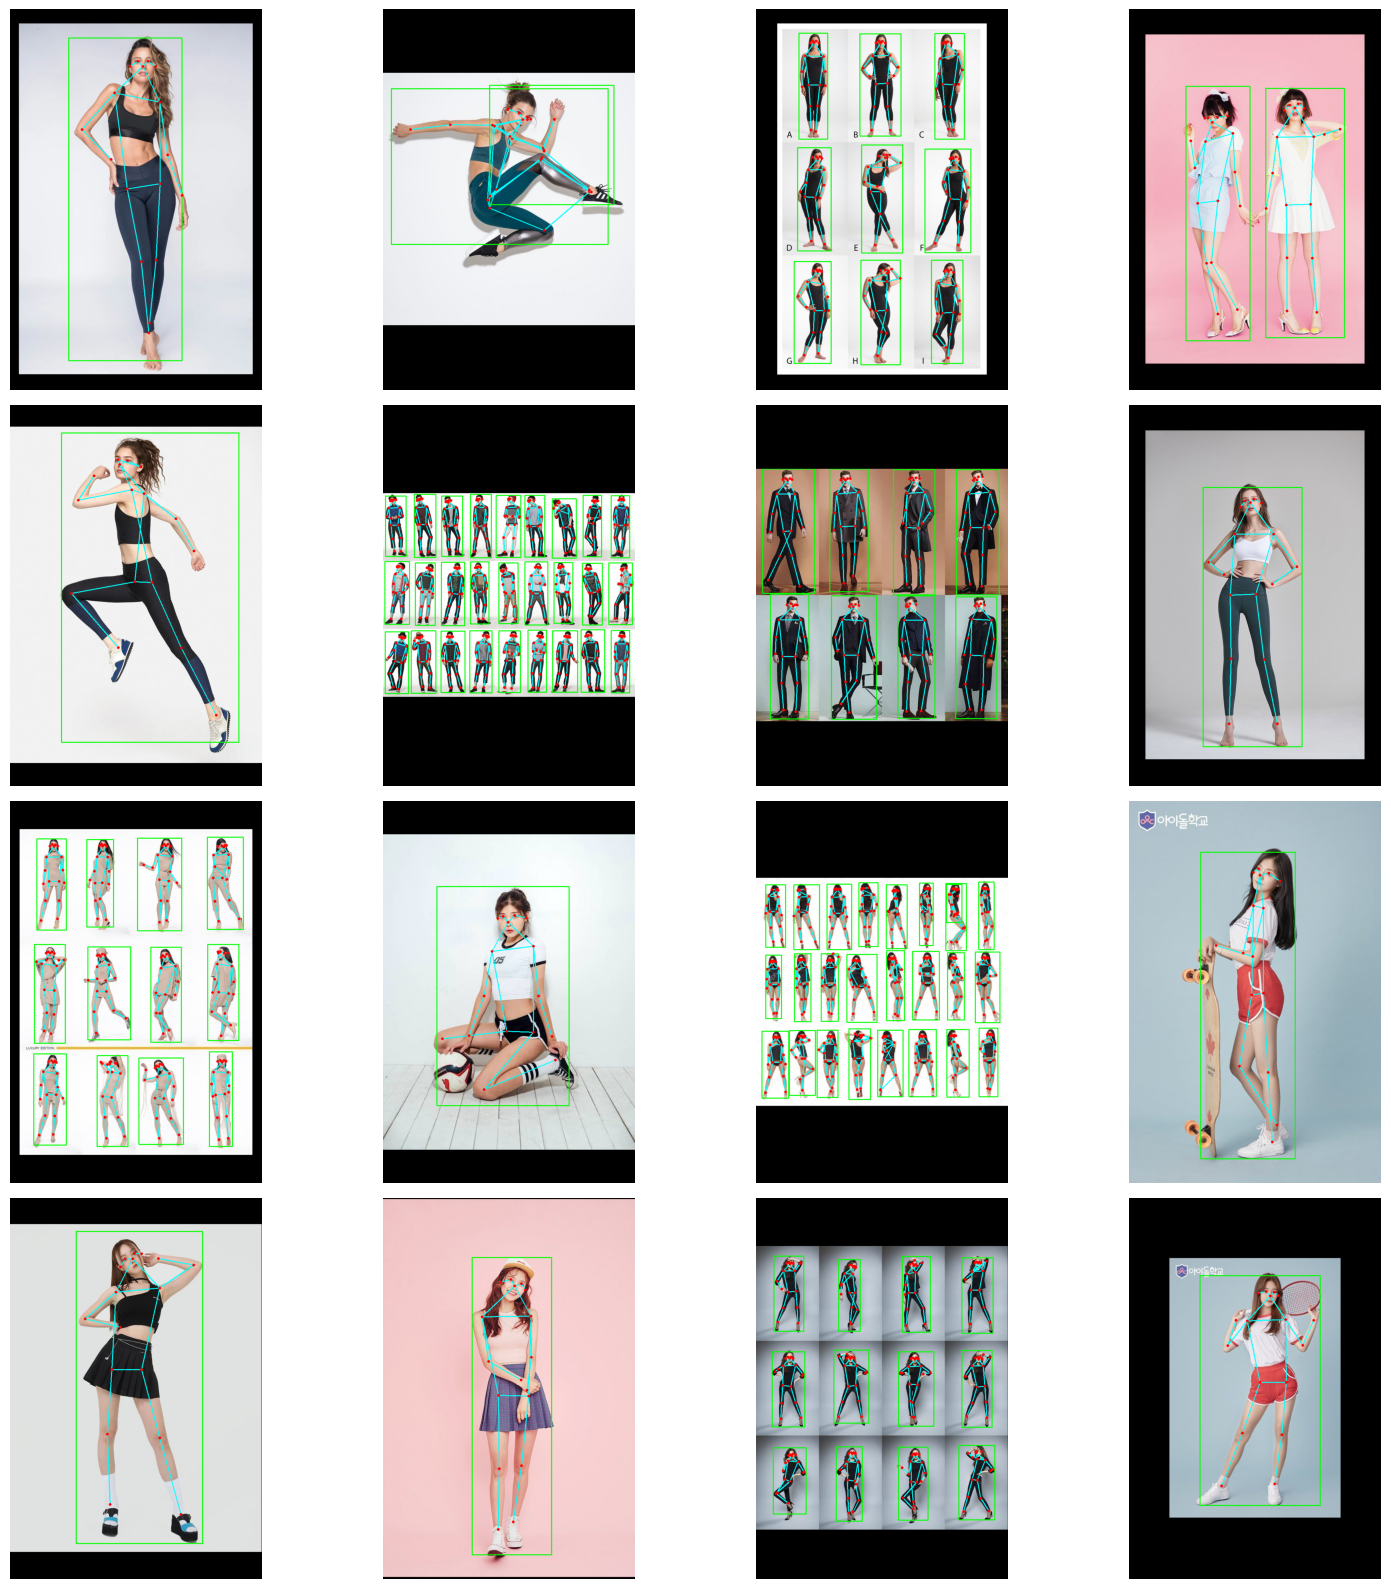

In [12]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime
import torch
from torchvision.ops import nms

# --- Config ---
val_dir = "/content/gdrive/MyDrive/Pytorch-Models/datasets/pose-tests"
onnx_path = "keypointrcnn_pose_human.onnx"

conf_thr = 0.2
num_samples = 16
pairs = [
    [0, 1], [0, 2],       # Nose to eyes
    [1, 3], [2, 4],       # Eyes to ears
    [0, 5], [0, 6],       # Nose to shoulders
    [5, 6],               # Shoulders
    [5, 7], [7, 9],       # Left Arm
    [6, 8], [8, 10],      # Right Arm
    [5, 11], [6, 12],     # Torso
    [11, 12],             # Hip
    [11, 13], [13, 15],   # Left Leg
    [12, 14], [14, 16],   # Right Leg
]

# --- Load Images ---
all_imgs = [f for f in os.listdir(val_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
selected_imgs = random.sample(all_imgs, min(num_samples, len(all_imgs)))

img_list = []
img_sizes = []

for img_name in selected_imgs:
    img_path = os.path.join(val_dir, img_name)
    img_cv = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    img_list.append((img_name, img_path, img_rgb))
    img_sizes.append(img_rgb.shape[:2])

max_height = max(h for h, w in img_sizes)
max_width = max(w for h, w in img_sizes)

# Remove padding and scale back to original image size
def rescale_coords(coord, scale, pad):
    return (coord - pad) / scale

# --- ONNX Runtime Setup ---
session = onnxruntime.InferenceSession(onnx_path, providers=["CUDAExecutionProvider"])
input_name = session.get_inputs()[0].name

# --- Plotting ---
cols = 4
rows = (len(img_list) + cols - 1) // cols
plt.figure(figsize=(4 * cols, 4 * rows))

# (Assuming imports and configs are same...)

for idx, (img_name, img_path, img_rgb) in enumerate(img_list):
    img = cv2.imread(img_path)
    h_orig, w_orig = img.shape[:2]

    img_resized, scale, pad_left, pad_top = resize_with_pad(img, (480, 640))
    img_input = img_resized.astype(np.float32) / 255.0
    img_input = img_input.transpose(2, 0, 1)[np.newaxis, :]  # (1, 3, H, W)

    outputs = session.run(None, {input_name: img_input})

    boxes, labels, scores, keypoints, kp_scores = outputs

    # Convert to numpy arrays
    boxes = np.array(boxes)
    scores = np.array(scores)
    keypoints = np.array(keypoints)
    kp_scores = np.array(kp_scores)

    # Apply NMS
    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)
    keep = nms(boxes_tensor, scores_tensor, iou_threshold=0.5)

    boxes = boxes_tensor[keep].numpy()
    scores = scores_tensor[keep].numpy()
    keypoints = keypoints[keep]
    kp_scores = kp_scores[keep]

    # Minimal fix: if only one detection, ensure keypoints and kp_scores have batch dimension
    if len(boxes) == 1:
        if keypoints.ndim == 2:  # shape (17, 3) instead of (1, 17, 3)
            keypoints = keypoints[np.newaxis, ...]
        if kp_scores.ndim == 1:  # shape (17,) instead of (1, 17)
            kp_scores = kp_scores[np.newaxis, ...]

    img_vis = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    for i in range(len(scores)):
        if scores[i] < conf_thr:
            continue
        # Boxes: rescale and clip
        x1, y1, x2, y2 = boxes[i]
        x1 = rescale_coords(x1, scale, pad_left)
        x2 = rescale_coords(x2, scale, pad_left)
        y1 = rescale_coords(y1, scale, pad_top)
        y2 = rescale_coords(y2, scale, pad_top)

        x1, x2 = np.clip([x1, x2], 0, w_orig - 1).astype(int)
        y1, y2 = np.clip([y1, y2], 0, h_orig - 1).astype(int)

        cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

        kpts_scaled = []
        for k, kpt in enumerate(keypoints[i]):
            kp_score = kp_scores[i][k]
            if kp_score > conf_thr:
                x_kp, y_kp, _ = kpt
                x_kp = rescale_coords(x_kp, scale, pad_left)
                y_kp = rescale_coords(y_kp, scale, pad_top)
                x_kp = int(np.clip(x_kp, 0, w_orig - 1))
                y_kp = int(np.clip(y_kp, 0, h_orig - 1))
                kpts_scaled.append((x_kp, y_kp))
            else:
                kpts_scaled.append(None)

        # Draw lines first
        for (p1, p2) in pairs:
            if p1 < len(kpts_scaled) and p2 < len(kpts_scaled):
                if kpts_scaled[p1] is not None and kpts_scaled[p2] is not None:
                    cv2.line(img_vis, kpts_scaled[p1], kpts_scaled[p2], (0, 255, 255), 2)

        # Then draw circles on top
        for pt in kpts_scaled:
            if pt is not None:
                cv2.circle(img_vis, pt, 4, (255, 0, 0), -1)

    # Optional: padding for visualization — remove or keep as you like
    h, w = img_vis.shape[:2]
    top = (max_height - h) // 2
    bottom = max_height - h - top
    left = (max_width - w) // 2
    right = max_width - w - left
    img_padded = cv2.copyMakeBorder(img_vis, top, bottom, left, right,
                                    borderType=cv2.BORDER_CONSTANT, value=(0, 0, 0))

    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img_padded)
    plt.axis('off')

plt.tight_layout()
plt.show()